# Space & Time coverages
=========================

This notebook shows:

1. How to **create** Space-Time coverages of the 2MASS image catalog and the XMM_DR8 catalog
2. How to **perform logical operations** (e.g. intersection) of two Space-Time coverages
3. How to **filter** a catalog by a Space-Time coverage
4. How to **save** a Space-Time coverage in a FITS file
5. How to **vizualize** Space-Time coverages within a specific time frame
------------------------------------------------------------------
## 1. Space-Time coverages creation of *2MASS* and *XMM_DR8*

In [1]:
from mocpy import WCS, STMOC, TimeMOC
from astropy.coordinates import ICRS
import numpy as np
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time, TimeDelta
import ipywidgets as widgets

from astroquery.vizier import Vizier

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Creation of the Space-Time coverage of 2MASS at the depth (time, space) = 23, 7 i.e.:
- a **time** resolution of ~3 days
- a **spatial** resolution of ~27 arcsecs

In [3]:
# Loading the data
two_mass_data = Table.read(
    "./../resources/STMOC/2MASS-list-images.fits.gz",
    format="fits",
)

# Definition of the times, longitudes and latitudes
times_2mass = Time(two_mass_data["mjd"].data, format="mjd", scale="tdb")
lon_2mass = two_mass_data["ra"].quantity
lat_2mass = two_mass_data["dec"].quantity
print("Number of rows in 2MASS: ", lon_2mass.shape[0])

Number of rows in 2MASS:  4879128


In [4]:
%%time
# Creation of the STMOC ~ wait around 1 minute
time_depth = 23
spatial_depth = 7
two_mass = STMOC.from_times_positions(
    times_2mass,
    time_depth,
    lon_2mass,
    lat_2mass,
    spatial_depth,
)

CPU times: user 11.4 s, sys: 17.8 s, total: 29.2 s
Wall time: 18.5 s


In [5]:
print("Time of the first observation: ", two_mass.min_time.iso)
print("Time of the last observation: ", two_mass.max_time.iso)

Time of the first observation:  1997-06-03 20:25:27.103
Time of the last observation:  2001-02-18 03:38:35.462


---------------------------------------------
### Query a ST-MOC by a time range

Let's query the ST-MOC of **2MASS** to retrieve the regions being observed each year.

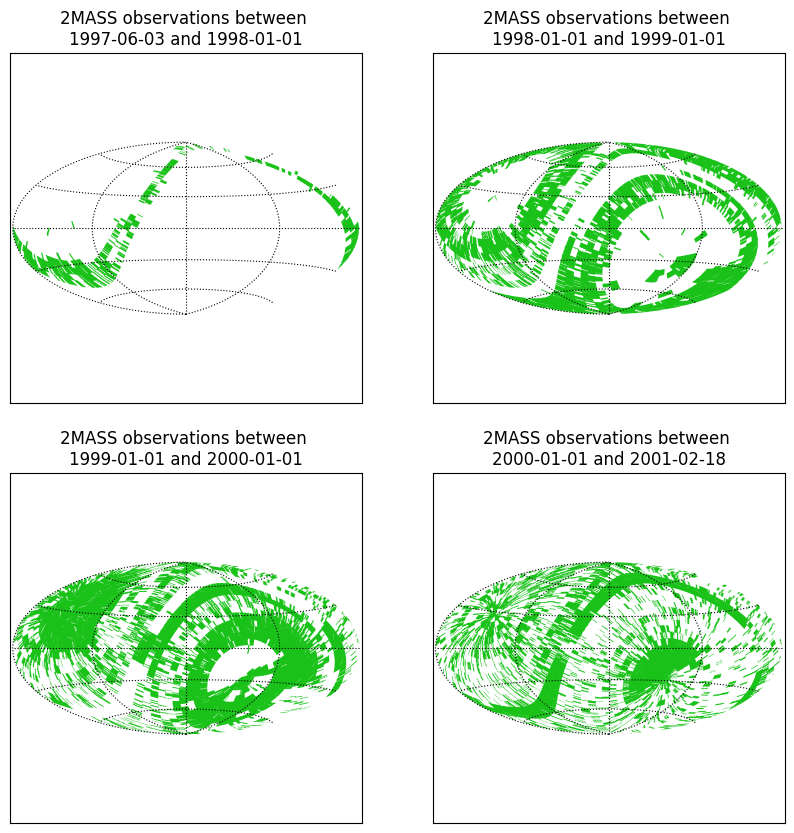

In [6]:
def add_to_plot(fig, label, wcs, title, moc):
    """Add a MOC to a plot."""
    ax = fig.add_subplot(label, projection=wcs)

    ax.grid(color="black", linestyle="dotted")
    ax.set_title(title)
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")

    moc.fill(ax=ax, wcs=wcs, alpha=0.9, fill=True, linewidth=0, color="#00bb00")
    # moc.border(ax=ax, wcs=wcs, linewidth=1, color="green")


fig = plt.figure(figsize=(10, 10))

time_ranges = Time(
    [
        [["1997-06-03", "1998-01-01"]],
        [["1998-01-01", "1999-01-01"]],
        [["1999-01-01", "2000-01-01"]],
        [["2000-01-01", "2001-02-18"]],
    ],
    format="iso",
    scale="tdb",
    out_subfmt="date",
)
with WCS(
    fig,
    fov=330 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="galactic"),
    coordsys="galactic",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    for i in range(0, 4):
        tmoc = TimeMOC.from_time_ranges(
            min_times=time_ranges[i][0, 0],
            max_times=time_ranges[i][0, 1],
            delta_t=TimeDelta(1e-6, scale="tdb", format="sec"),
        )

        moc_2mass = two_mass.query_by_time(tmoc)
        title = "2MASS observations between \n{} and {}".format(
            time_ranges[i][0, 0].iso,
            time_ranges[i][0, 1].iso,
        )
        id_subplot = int("22" + str(i + 1))
        add_to_plot(fig, id_subplot, wcs, title, moc_2mass)

plt.show()

Creation of the Space-Time coverage of XMM_DR8 at the depth (time, space) = 10, 7

In [7]:
# Loading & preparing the data
xmm_dr8_data = Table.read("../resources/STMOC/vizier_votable.b64")
times_xmm = Time(xmm_dr8_data["MJD0"].data, format="mjd", scale="tdb")
lon_xmm = xmm_dr8_data["RA_ICRS"].quantity
lat_xmm = xmm_dr8_data["DE_ICRS"].quantity
print("Number of rows in XMM_DR8: ", lon_xmm.shape[0])

Number of rows in XMM_DR8:  531454


In [8]:
%%time
# Create the STMOC
xmm_dr8_stmoc = STMOC.from_times_positions(
    times_xmm,
    time_depth,
    lon_xmm,
    lat_xmm,
    spatial_depth,
)

CPU times: user 1.42 s, sys: 353 ms, total: 1.77 s
Wall time: 728 ms


------------------------------------------------------------------
## 2. Intersection between the *2MASS* and *XMM_DR8* Space-Time coverages

ST-MOCs are very convinient when it comes to perform logical operations between them (as it is already possible with spatial footprints).

As an example, it is possible to **retrieve the areas that have been observed at the same time by the 2MASS and XMM survey**! It benefits from the good performance of MOC (thanks to its core functions written in Rust).

In [9]:
%%time
# Compute their intersection and check that it is not empty
xmm_inter_2mass = xmm_dr8_stmoc.intersection(two_mass)

print("Is the MOC intersection empty?:", xmm_inter_2mass.is_empty())

print("Time of the first observation:", xmm_inter_2mass.min_time.iso)
print("Time of the last observation:", xmm_inter_2mass.max_time.iso)

Time of the first observation: 2000-02-18 06:49:16.163
Time of the last observation: 2000-11-05 03:55:44.532
CPU times: user 6.84 ms, sys: 221 µs, total: 7.07 ms
Wall time: 7.01 ms


-------------------------------------------
## 3. Filter catalogs by a Space-Time coverage

ST-MOCs can be used to retrieve the sources in *2MASS* and *XMM_DR8* that have
been observed at the same time i.e. **within a ~3 days time resolution** and
a **27 arcsec spatial resolution**.

Let's retrieve the XMM sources being observed at the **same time** by 2MASS.

In [10]:
%%time
# Filtering a 4.8M rows table is quite fast
mask_xmm = xmm_inter_2mass.contains(times_xmm, lon_xmm, lat_xmm)
sources_xmm = xmm_dr8_data[mask_xmm]

print(f"\n {len(sources_xmm)} sources in XMM\n")
sources_xmm


 10 sources in XMM

CPU times: user 240 ms, sys: 37.3 ms, total: 278 ms
Wall time: 278 ms


RA_ICRS,DE_ICRS,MJD0,recno
deg,deg,d,
float64,float64,float64,int32
89.637991,-50.397917,51604.6465,147242
89.665918,-50.524772,51604.6465,147293
89.787931,-50.275894,51604.6465,147436
89.818302,-50.509235,51604.6465,147462
89.910377,-50.361675,51604.6465,147530
89.920087,-50.386144,51604.6465,147542
89.936948,-50.444740,51604.6465,147560
89.945907,-50.465488,51604.6465,147577


One can then use **astroquery.vizier** to get more informations about the filtered sources.

In [ ]:
xmm_skycoords = SkyCoord(
    sources_xmm["RA_ICRS"].data,
    sources_xmm["DE_ICRS"].data,
    unit="deg",
    frame=ICRS(),
)

# Query the IX/55/xmm3r8s catalog with the three first positions + 0.1 arcsec
result = Vizier.query_region(
    xmm_skycoords[:3],
    radius=Angle(0.1, "arcsec"),
    catalog="IX/55/xmm3r8s",
)[0]
result

-------------------------------------------------------------
## 4. Save into a FITS file

In [ ]:
xmm_inter_2mass.save("xmm_inter_2mass_stmoc.fits", format="fits", overwrite=True)

------------------------------------------------
## 5. Vizualize a Space-Time coverage interactively

- An interactive slider allows to select a time range. Whenever the slider moves, the ST-MOC is queried by the new time range. Each **time query gives back the spatial footprint during that time** (i.e. a mocpy.MOC object).
- You can change the field of view to zoom in (resp. zoom out) if you want. By reducing the FoV you will be able to vizualize the sources in XMM filtered by the intersection Space-Time coverage.

In [ ]:
output = widgets.Output()


def update(change):
    """Define an interactive plot for time MOCs."""
    global t, output, time_slider
    global last_t1, last_t2
    global moc
    output.clear_output(wait=True)

    new_values = time_slider.value if change is None else change.new

    new_t1, new_t2 = new_values

    tmoc_constraint = TimeMOC.from_time_ranges(
        min_times=Time([new_t1], format="mjd", scale="tdb"),
        max_times=Time([new_t2], format="mjd", scale="tdb"),
        delta_t=TimeDelta(1e-6, scale="tdb", format="sec"),
    )
    # Query the Space-Time coverages with the same time frame
    # This operation returns a spatial coverage and is pretty fast thanks to
    # the data-structure used for storing Space-Time coverages.
    moc_2mass = two_mass.query_by_time(tmoc_constraint)
    moc_xmm_dr8 = xmm_dr8_stmoc.query_by_time(tmoc_constraint)
    moc_xmm_dr8_inter_2mass = xmm_inter_2mass.query_by_time(tmoc_constraint)

    # Plot the spatial coverages
    with output:
        fig = plt.figure(111, figsize=(15, 10))

        with WCS(
            fig,
            fov=50 * u.deg,
            center=SkyCoord(140, 30, unit="deg", frame="galactic"),
            coordsys="galactic",
            rotation=Angle(0, u.degree),
            projection="AIT",
        ) as wcs:
            ax = fig.add_subplot(1, 1, 1, projection=wcs)
            # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
            moc_2mass.fill(
                ax=ax,
                wcs=wcs,
                alpha=0.5,
                fill=True,
                color="green",
                label="2mass",
            )
            moc_xmm_dr8.fill(
                ax=ax,
                wcs=wcs,
                alpha=0.5,
                fill=True,
                color="red",
                label="xmm_dr8",
            )
            moc_xmm_dr8_inter_2mass.fill(
                ax=ax,
                wcs=wcs,
                alpha=0.5,
                fill=True,
                color="blue",
                label="xmm_dr8 inter 2mass",
            )

            # Plot the sources contained into `xmm_inter_2mass`
            skycoords = SkyCoord(
                sources_xmm["RA_ICRS"].data,
                sources_xmm["DE_ICRS"].data,
                unit="deg",
                frame=ICRS(),
            )
            X, Y = SkyCoord.to_pixel(skycoords, wcs)
            ax.scatter(
                X,
                Y,
                color="yellow",
                alpha=1,
                marker="x",
                label="sources from XMM filtered through \nxmm_dr8 inter 2mass",
                zorder=2,
            )

            ax.legend(loc="lower left")

        plt.xlabel("GLON")
        plt.ylabel("GLAT")

        plt.title(
            "Coverage of 2MASS images, XMM_DR8 and their intersection between MJD %d and %d"
            % (new_values[0], new_values[1]),
        )
        plt.grid(color="black", linestyle="dotted")
        plt.show()

In [ ]:
min_time = int(np.min(two_mass_data["mjd"])) - 1
max_time = int(np.max(two_mass_data["mjd"])) + 1

time_slider = widgets.IntRangeSlider(
    value=[51594, 51917],
    min=min_time,
    max=max_time,
    step=1,
    description="MJD interval:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    layout={"width": "90%"},
)

In [ ]:
# In blue is a region that has been observed by 2MASS and XMM_DR8 at the same time
time_slider.observe(update, "value")
update(None)
widgets.VBox([time_slider, output])